In [152]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
# Normality test to detect if any column of a dataframe have normal-distribution

In [96]:
from utils import *

In [136]:
# Substitua 'seu_dataframe.csv' pelo nome do seu arquivo CSV ou DataFrame
df = pd.read_csv("datasets/diabetes_prediction_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [137]:
missing_values_per_row = df.isnull().sum(axis=1)
num_rows_with_missing_data = (missing_values_per_row > 0).sum()
print(f'Rows with missing data (qty): {num_rows_with_missing_data}')

Rows with missing data (qty): 0


In [132]:
neg, pos = np.bincount(df['diabetes'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 100000
    Positive: 8500 (8.50% of total)



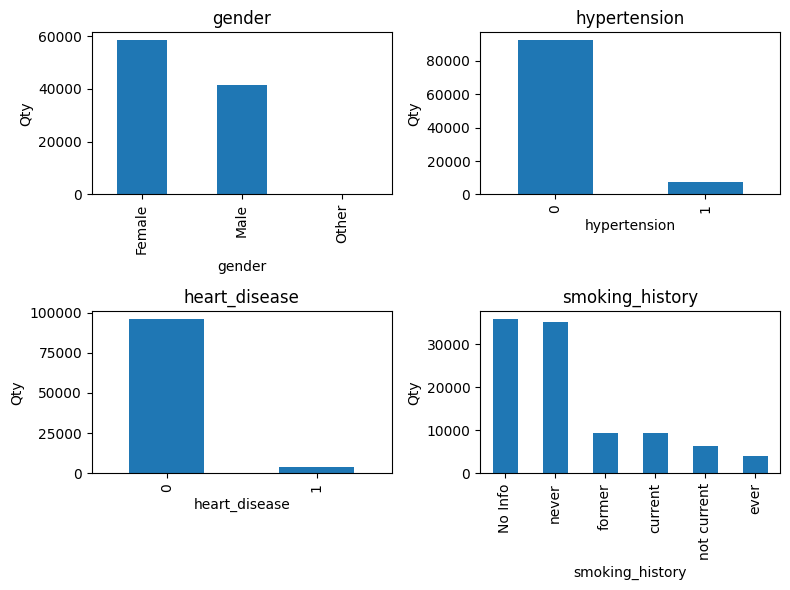

In [146]:
columns_to_plot = ['gender', 'hypertension', 'heart_disease', 'smoking_history']

num_columns = len(columns_to_plot)
num_rows = (num_columns + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(8, 6))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    counts = df[column].value_counts()
    counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Qty')

plt.tight_layout()

plt.show()

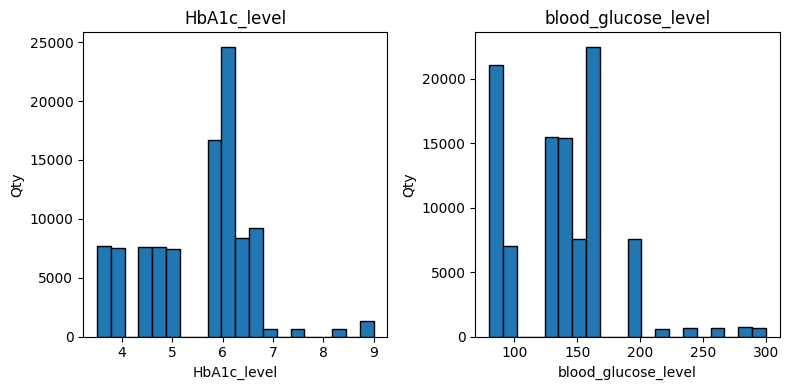

In [148]:
columns_to_plot = ['HbA1c_level', 'blood_glucose_level']

num_columns = len(columns_to_plot)
num_rows = (num_columns + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(8, 4))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    df[column].plot(kind='hist', ax=axes[i], bins=20, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Qty')

plt.tight_layout()
plt.show()

In [149]:
normality_test(df, ['heart_disease','hypertension','age','HbA1c_level', 'blood_glucose_level'])

/Users/pedrocnf/miniconda3/envs/p39/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Coluna,p_valor,Normal?
0,heart_disease,0.0,False
1,hypertension,0.0,False
2,age,0.0,False
3,HbA1c_level,0.0,False
4,blood_glucose_level,0.0,False


In [150]:
df_class_0 = df[df['diabetes'] == 0]
df_class_1 = df[df['diabetes'] == 1]

differences_test(df_class_0, df_class_1, ['heart_disease','hypertension','age','HbA1c_level', 'blood_glucose_level'])

,Coluna,p_valor,Different?
0,heart_disease,0.0,False
1,hypertension,0.0,False
2,age,0.0,False
3,HbA1c_level,0.0,False
4,blood_glucose_level,0.0,False


In [155]:
categorical_string = ['gender','smoking_history']
numeric = ['age', 'hypertension', 'heart_disease','bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

In [ ]:
encoder = OneHotEncoder(sparse=False)

encoded_data = encoder.fit_transform(df[categorical_string])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_string))

In [156]:
df_main = pd.concat([encoded_df,df[numeric]], axis = 1)

In [157]:
df_main

,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,80.0,0,1,25.19,6.6,140,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,54.0,0,0,27.32,6.6,80,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,0,0,27.32,5.7,158,0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,36.0,0,0,23.45,5.0,155,0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,76.0,1,1,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,80.0,0,0,27.32,6.2,90,0
99996,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,17.37,6.5,100,0
99997,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66.0,0,0,27.83,5.7,155,0
99998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,24.0,0,0,35.42,4.0,100,0


In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('diabetes', axis=1),  # Recursos, excluindo a coluna de classe
    df['diabetes'],  # Coluna de classe
    test_size=0.2,
    random_state=42
)


In [108]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['gender','smoking_history'])
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=['gender','smoking_history'], reference=train_data)

In [92]:
total_samples = len(y_train)
class_counts = np.bincount(y_train)
class_weights = total_samples / (len(np.unique(y_train)) * class_counts)


In [93]:
class_weights = class_weights / sum(class_weights)


In [94]:
class_weights

array([0.0849, 0.9151])

In [116]:
print(len(y_train))
print(np.bincount(y_train))
print(len(y_train)/(2 * np.bincount(y_train)[1]))

#len(y_train)/(2 * np.bincount(y_train['Class'])[1])

80000
[73208  6792]
5.889281507656066


In [130]:
params = {
    'objective': 'binary',  # ou 'multiclass' para problemas de classificação com várias classes
    'metric': 'binary_error',  # ou 'multi_error' para problemas de classificação com várias classes
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'num_round': 100,
    'verbose': 1,
}

/Users/pedrocnf/miniconda3/envs/p39/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=100, num_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Number of positive: 6792, number of negative: 73208
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 8
[LightGBM] [Warning] num_iterations is set=100, num_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084900 -> initscore=-2.377559
[LightGBM] [Info] Start training from score -2.377559


/Users/pedrocnf/Documents/DEV/ds-diabetes-detection/utils.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = metrics_df._append({


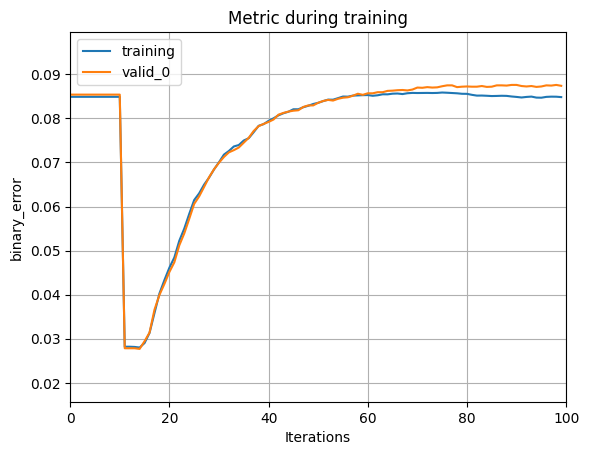

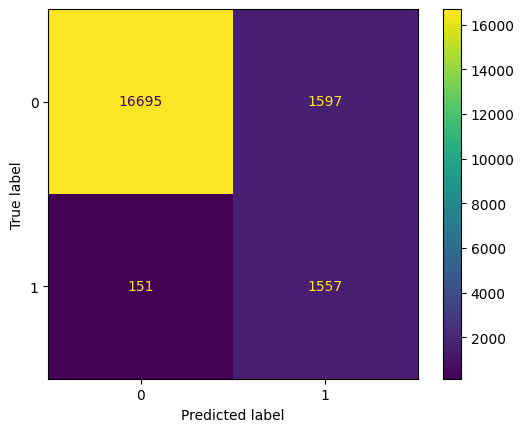

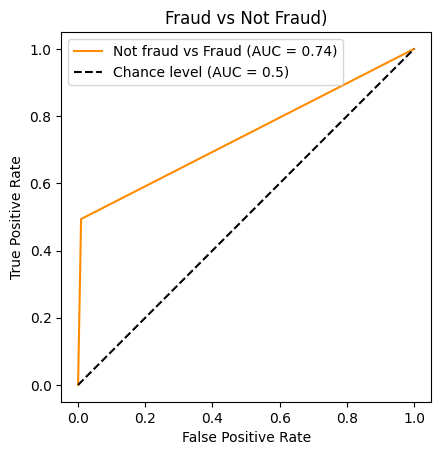

,Accuracy,F1-Score,Recall,Precision,AUC-ROC
0,0.9126,0.640477,0.911593,0.493659,0.979189


In [120]:
model_evaluation(params, X_train, y_train, X_test, y_test)

In [122]:
categorical_string = ['gender','smoking_history']
numeric = ['age', 'hypertension', 'heart_disease','bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']